In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from math import *
from astroML.time_series import generate_damped_RW
import argparse
import random
#%matplotlib qt
%matplotlib inline
import sys
np.set_printoptions(threshold=sys.maxsize)

In [2]:
data = np.loadtxt('RXJ1131_ALL.rdb',skiprows=2)
data1=np.genfromtxt('HE0435_ECAM.rdb',skip_header=2)
time = np.sort(np.concatenate((data[:,0],data1[:,0])))

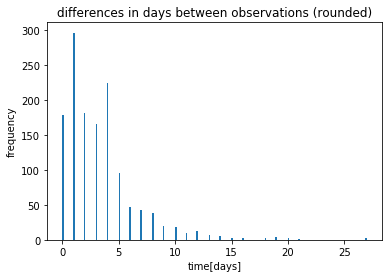

In [3]:
def hist_day(array,bins_):
    diff = np.array([])
    for i in range(1,len(array)):
        diff = np.append(diff,array[i]-array[i-1])
    rounded=np.round(diff)
    rounded = rounded[rounded<30]
    plt.hist(rounded,bins=bins_)
    plt.title('differences in days between observations (rounded)')
    plt.xlabel('time[days]')
    plt.ylabel('frequency')
    return diff,rounded,plt.show()
rounded = hist_day(time,200)[1]

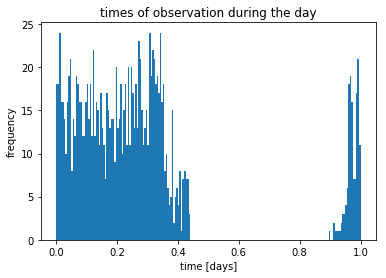

In [4]:
def hist_time(array,bins_):
    day_time = np.array([])
    for i in range(1,len(array)):
        day_time = np.append(day_time,array[i]-np.floor(array[i]))
    plt.hist(day_time,bins=bins_)
    plt.xlabel('time [days]')
    plt.ylabel('frequency')
    plt.title('times of observation during the day')
    return day_time, plt.show()
day_time = hist_time(time,200)[0]

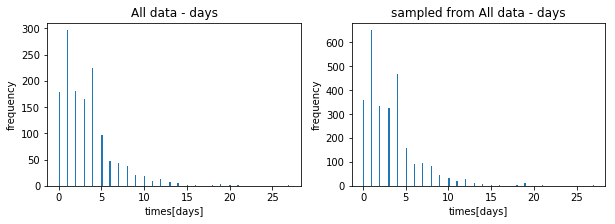

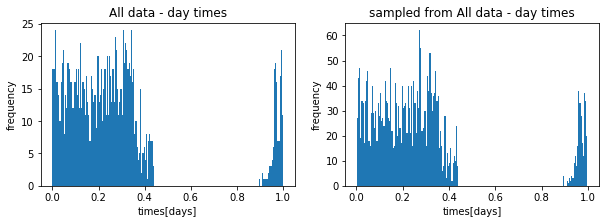

In [5]:
def sample_data(array,data_name,num,flag=False):  # array = time arrays
    '''array is the data to sample from
        data_name is the name of the data set
        num is the number of random values we want sampled
        flag: should be set to True if the random samples numbers need to be rounded'''
    bins_= 200
    data = array
    hist, bins = np.histogram(array, bins=bins_)

    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    values = np.random.rand(num)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]
    f = plt.figure(figsize=(10,3))
    f.add_subplot(121)
    plt.hist(data, bins_)
    plt.ylabel('frequency')
    plt.xlabel('times[days]')
    plt.title(data_name)
    f.add_subplot(122)
    if flag==True:
        random_from_cdf = np.round(random_from_cdf)
    plt.hist(random_from_cdf, bins_)
    plt.title('sampled from '+data_name)
    plt.ylabel('frequency')
    plt.xlabel('times[days]')
    return plt.show(),random_from_cdf
rand_days_ = sample_data(rounded,'All data - days',len(time)*2,True)[1]
rand_times_ = sample_data(day_time,'All data - day times',len(time)*2)[1]
rand_obs_diff = rand_days_+rand_times_

In [6]:
t_drive_new = np.array([np.min(time)])
i=0
while (np.max(t_drive_new)<np.max(time)) and (len(t_drive_new)<len(time)):
    t_drive_new = np.append(t_drive_new,t_drive_new[-1]+rand_obs_diff[i])
    i+=1

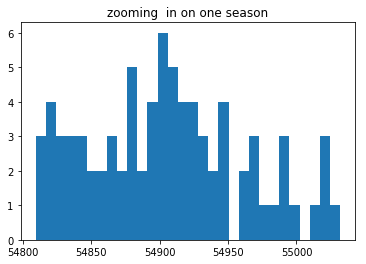

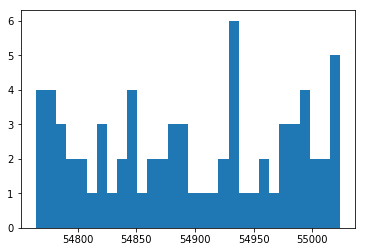

conclusion: I dont see how the two arrays of time can be said to be similar, when plotting 
a single season of observation, its not clear either, maybe one season is too small to see beyond the randomness
of the sampling.. I will look more into this later


In [18]:
# #%matplotlib qt
plt.hist(np.sort(time)[446:526],30)
plt.title('zooming  in on one season')
plt.show()
plt.hist(t_drive_new[509:581],30)
plt.show()
#plt.hist(np.sort(t_drive_new),30)

# print(np.sort(time))
# np.argwhere(np.sort(time)==54802.24547983)
# plt.hist(np.abs(np.sort(time)-np.sort(t_drive_new)))
# plt.show()
print('''conclusion: I dont see how the two arrays of time can be said to be similar, when plotting 
a single season of observation, its not clear either, maybe one season is too small to see beyond the randomness
of the sampling.. I will look more into this later''')

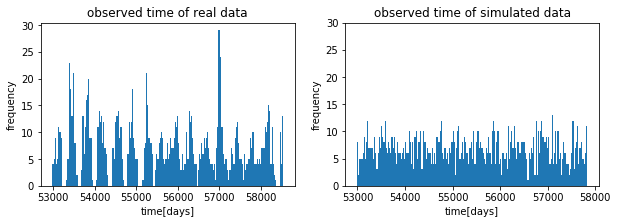

these are to compare the histogram of the time from the real data with the histogram of the 
simulated times. I dont know if they are supposed to be similar or not.


In [9]:
g = plt.figure(figsize=(10,3))
g.add_subplot(121)
plt.hist(time,200)
plt.title('observed time of real data')
plt.xlabel('time[days]')
plt.ylabel('frequency')
g.add_subplot(122)
plt.hist(t_drive_new,200)
plt.ylim(0,30)
plt.title('observed time of simulated data')
plt.xlabel('time[days]')
plt.ylabel('frequency')
plt.show()
print('''these are to compare the histogram of the time from the real data with the histogram of the 
simulated times. I dont know if they are supposed to be similar or not.''')

In [10]:
'''simulating data using the sampling about as the time axis'''

parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--time_initial'  , '-ti  ', type=float, default=-365.        ,help='Set the initial time (default: t=-365 [day])')
parser.add_argument('--time_final'    , '-tf  ', type=float, default=365.         ,help='Set the final time (default: t=365 [day])')
parser.add_argument('--delta_time'    , '-dt  ', type=float, default=0.1          ,help='Set the time interval (default: dt=0.1 [day])')
parser.add_argument('--fname'         , '-fn  ', type=str  , default='LC_DRW.txt' ,help='Set the output filename (default: LC_DRW.txt)')

parser.add_argument('--tau'           , '-tau ', type=float, default=300          ,help='Set the relaxation time (default: tau=300)')
parser.add_argument('--strc_func_inf' , '-sf  ', type=float, default=0.1          ,help='Set the structure function at infinity (default: SFinf=0.1)')
parser.add_argument('--xmean'         , '-xmu ', type=float, default=1.           ,help='Set the mean value of random walk (default: Xmean=1.)')
parser.add_argument('--ran_seed'      , '-sn  ', type=str  , default='123'        ,help='Set the random seed (r: random, snnn: random seed)')
parser.add_argument('--redshift_src'  , '-zs'  , type=float, default=0.5          ,help='Set the redshift of source (default: zs=0.5)')

parser.add_argument('--target_dir'    , '-td'  ,             default='.',          help='Set the output directory')


args = parser.parse_args()

ti = args.time_initial
tf = args.time_final
dt = args.delta_time
fn = args.fname

xmean = args.xmean
tau = args.tau
SFinf = args.strc_func_inf
zs = args.redshift_src
sn = args.ran_seed

stem_out = args.target_dir


if (sn == 'r'):
    np.random.seed()
else:
    sn = int(sn)
    np.random.seed(sn)


In [11]:
sn = np.random.randn(1)
time_delay = np.random.rand(4)*500 # time delays: these are large, just to see effects throughout process

t_drive = t_drive_new
f_drive = generate_damped_RW(t_drive, tau=tau, z=zs, SFinf=SFinf, xmean=xmean,random_state=5)

### Part 3

In [12]:
# 0th image starts from 0 to 1368 in indices
# 1st image starts from 1369 to 2737 in indices
# 2nd image starts from 2738 to 4106 in indices
# 3rd image starts from 4106 to 5475 in indices

In [13]:
# concatenating all the shifted time samples
sample = np.concatenate((t_drive+time_delay[0],t_drive+time_delay[1],t_drive+time_delay[2],t_drive+time_delay[3]))

In [14]:
# gives the indices of time shifted samples within the sorted, concatenated array
'''all that needs to be understood from this is that the sanity check will work, uncomment 2nd line of cell below to try'''
index0 = []
for i in range(1369):
    index0.append(np.where(np.argsort(sample) == i))
index0 = np.array(index0).flatten()

index1 = []
for i in range(1369,2738):
    index1.append(np.where(np.argsort(sample) == i))
index1 = np.array(index1).flatten()

index2 = []
for i in range(2738,4107):
    index2.append(np.where(np.argsort(sample) == i))
index2 = np.array(index2).flatten()

index3 = []
for i in range(4107,5476):
    index3.append(np.where(np.argsort(sample) == i))
index3 = np.array(index3).flatten()

In [15]:
'''sanity check, replace 3 with 1,0,2, finding the time shifted samples that are distributed 
in the sorted concatenated array'''
#np.sort(sample)[index3] == (t_drive+time_delay[3])

'sanity check, replace 3 with 1,0,2, finding the time shifted samples that are distributed \nin the sorted concatenated array'

In [16]:
# generating magnitudes
f = generate_damped_RW(np.sort(sample), tau=tau, z=zs, SFinf=SFinf, xmean=xmean,random_state=5)
# finding the magnitudes corresponding to each time shifted sample
f_t0 = f[index0]
f_t1 = f[index1]
f_t2 = f[index2]
f_t3 = f[index3]

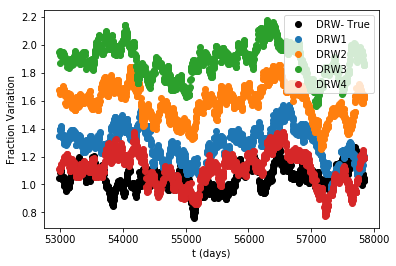

In [17]:
#%matplotlib qt

plt.plot(t_drive, f_drive, 'o', color='black', label='DRW- True')
plt.plot(t_drive, f_t0+0.3, 'o', label='DRW1')  
plt.plot(t_drive, f_t1+0.6, 'o',  label='DRW2')  
plt.plot(t_drive ,f_t2+0.9, 'o', label='DRW3')  
plt.plot(t_drive, f_t3+0.12, 'o', label='DRW4')  

plt.xlabel('t (days)')
plt.ylabel('Fraction Variation')
plt.legend()
plt.show()